In [9]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import ipaddress;
from imblearn.over_sampling import SMOTE;
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import StandardScaler



fraud_data = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_data = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
credit_card_data = pd.read_csv('../data/raw/creditcard.csv')

# File data overview
print(fraud_data.info())
print(ip_data.info())
print(credit_card_data.info())

# Check missing values
print(fraud_data.isnull().sum())
print(ip_data.isnull().sum())
print(credit_card_data.isnull().sum())

# Example: Fill missing 'age' in fraud_data with median
fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)

# Drop rows with any remaining missing values (if few)
fraud_data.dropna(inplace=True)
ip_data.dropna(inplace=True)
credit_card_data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   

C:\Users\samib\AppData\Local\Temp\ipykernel_12156\806205634.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)


In [10]:
# Data Cleaning
fraud_data.drop_duplicates(inplace=True)
ip_data.drop_duplicates(inplace=True)
credit_card_data.drop_duplicates(inplace=True)

# Convert to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Ensure numeric types
fraud_data['purchase_value'] = pd.to_numeric(fraud_data['purchase_value'], errors='coerce')
ip_data['lower_bound_ip_address'] = pd.to_numeric(ip_data['lower_bound_ip_address'], errors='coerce')
ip_data['upper_bound_ip_address'] = pd.to_numeric(ip_data['upper_bound_ip_address'], errors='coerce')

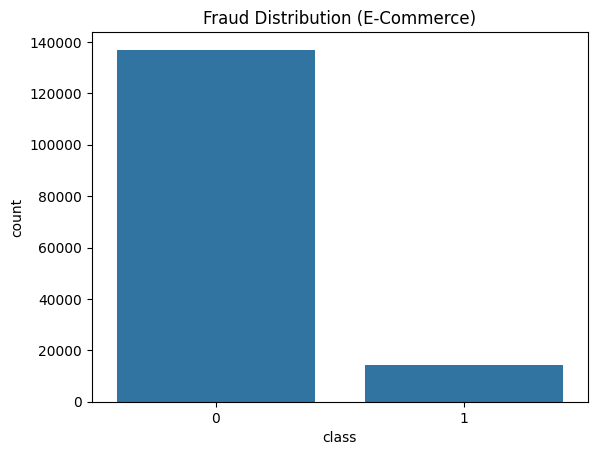

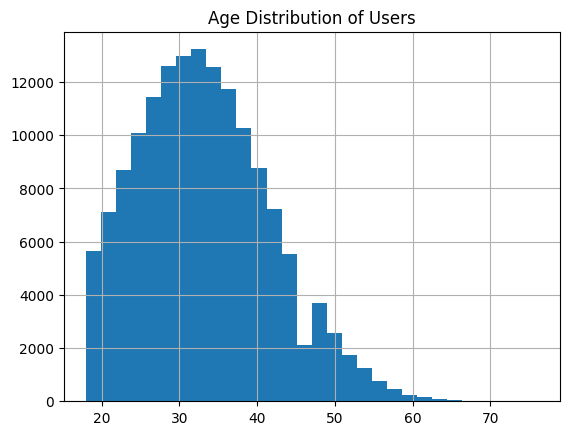

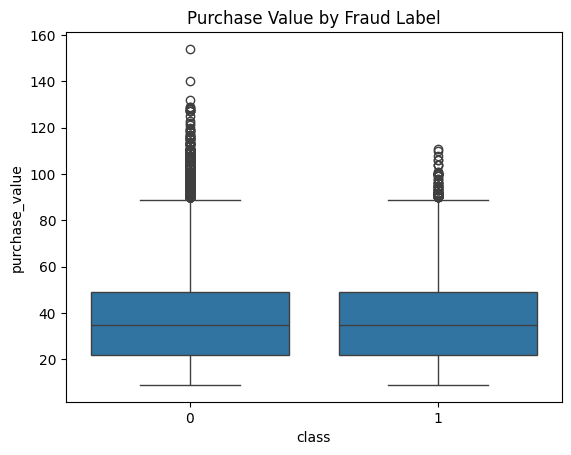

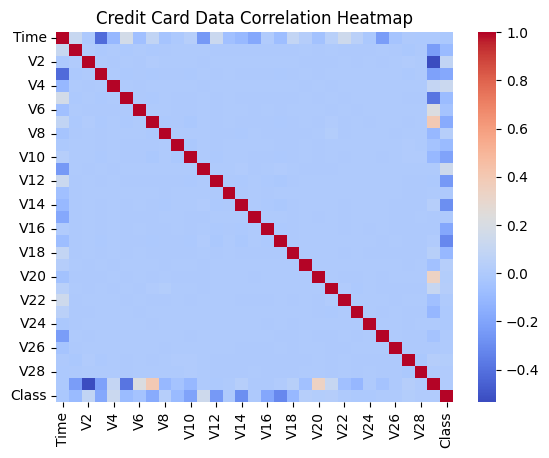

In [11]:
# Unvariated analysis
sns.countplot(x='class', data=fraud_data)
plt.title('Fraud Distribution (E-Commerce)')
plt.show()

# Age Distribution
fraud_data['age'].hist(bins=30)
plt.title('Age Distribution of Users')
plt.show()

# Bivariate analysis
# Boxplot for purchase value by class
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title("Purchase Value by Fraud Label")
plt.show()

# Correlation heatmap (creditcard.csv)
sns.heatmap(credit_card_data.corr(), cmap='coolwarm')
plt.title("Credit Card Data Correlation Heatmap")
plt.show()

In [14]:
# Convert IP address to integer (if not already int)
fraud_data['ip_int'] = fraud_data['ip_address'].astype(int)

# Merge fraud data with IP data using interval matching
ip_data_sorted = ip_data.sort_values('lower_bound_ip_address')
def find_country(ip_int):
    row = ip_data_sorted[
        (ip_data_sorted['lower_bound_ip_address'] <= ip_int) &
        (ip_data_sorted['upper_bound_ip_address'] >= ip_int)
    ]
    return row['country'].values[0] if not row.empty else 'Unknown'

fraud_data['country'] = fraud_data['ip_int'].apply(find_country)

In [16]:
# Number of transactions per user
user_trx_counts = fraud_data.groupby('user_id').size().reset_index(name='txn_count')
fraud_data = fraud_data.merge(user_trx_counts, on='user_id')

In [17]:
# Time Based Features
# Hour of day feature
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
# Day of week feature
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
# Time since signup (in hours)
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

In [18]:
# Data Transformation
# Check class distribution
print(fraud_data['class'].value_counts(normalize=True))

# Split features and target
X = fraud_data.drop(columns=['class']).select_dtypes(include=[np.number])
y = fraud_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [19]:
# Normalization and Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_smote)
X_test_scaled = scaler.transform(X_test)

# Encode Categorical Features
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'sex'], drop_first=True)